In [25]:
# Library Requirements 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [26]:
# Hide all warnings
warnings.resetwarnings()
warnings.filterwarnings('ignore')

# Technical Analysis
We will try a technical analysis to find some interesting insights to apply for our models

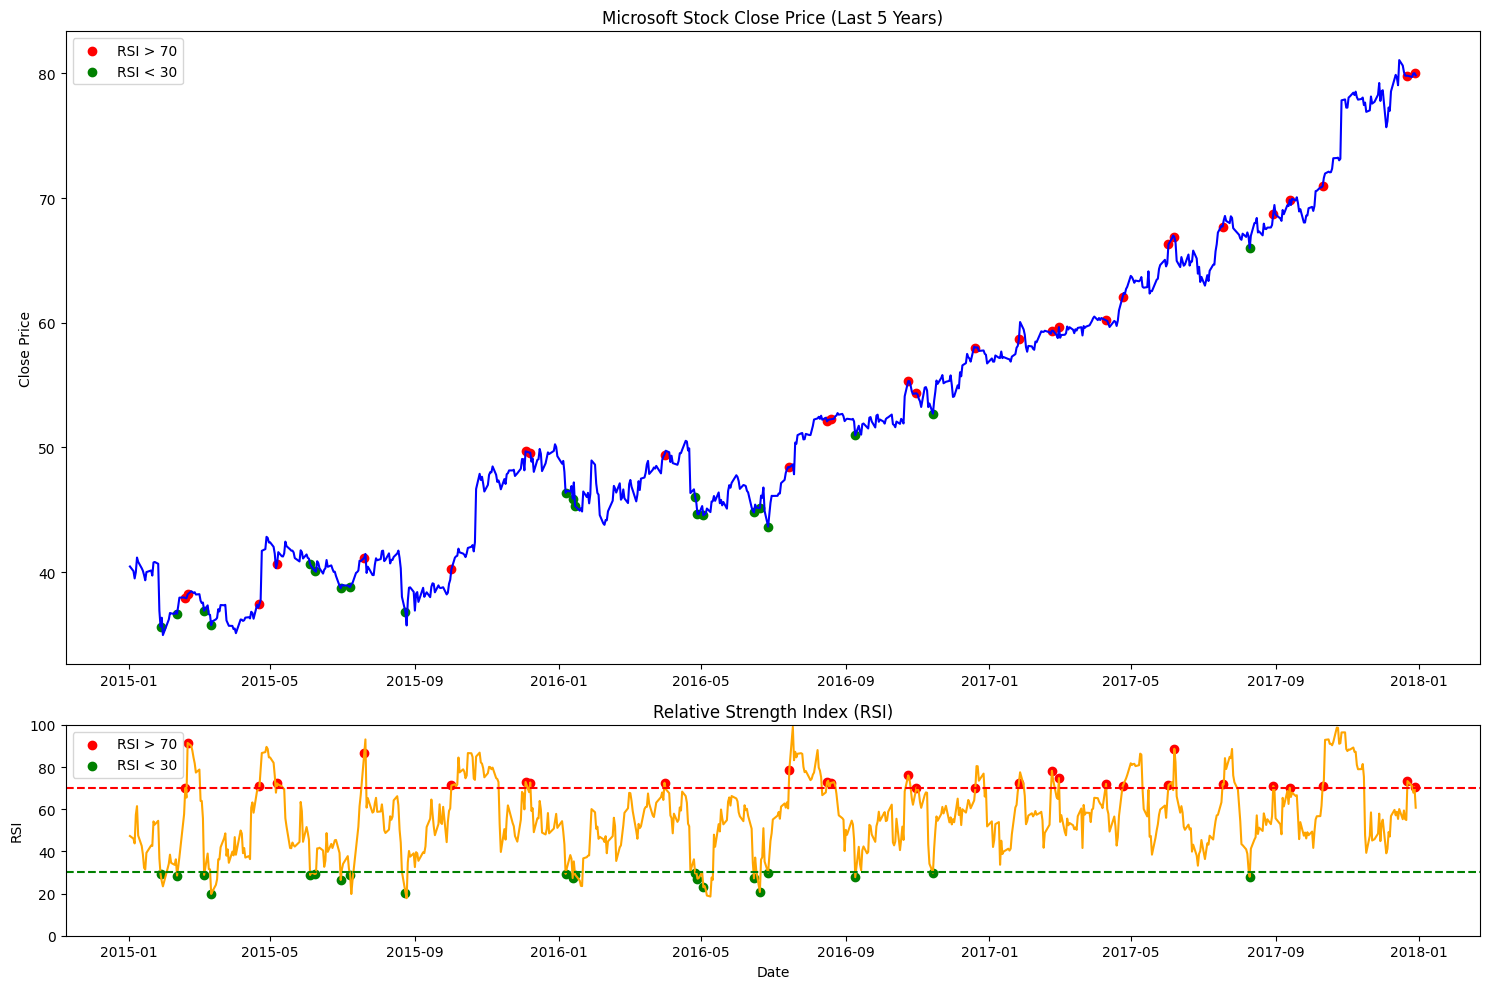

In [27]:
# Read the data
file_path = 'MSFT.csv'
msft_data = pd.read_csv(file_path)
msft_data['Date'] = pd.to_datetime(msft_data['Date'])

# Filter data for the last 5 years
latest_date = msft_data['Date'].max()
five_years_ago = latest_date - pd.DateOffset(years=10)
filtered_data = msft_data[msft_data['Date'] > five_years_ago]

# Calculate RSI / or can use library to calculate
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Calculate RSI for the 'Close' prices
filtered_data['RSI'] = calculate_rsi(filtered_data['Close'])
filtered_data= filtered_data[filtered_data['Date']<'2018-01-01']
filtered_data= filtered_data[filtered_data['Date']>'2015-01-01']
# Identifying points where RSI crosses the upper (70) and lower (30) thresholds
upper_threshold = 70
lower_threshold = 30

crossings_up = filtered_data[(filtered_data['RSI'] > upper_threshold) & (filtered_data['RSI'].shift(1) <= upper_threshold)]
crossings_down = filtered_data[(filtered_data['RSI'] < lower_threshold) & (filtered_data['RSI'].shift(1) >= lower_threshold)]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

# Close price with points where RSI crosses thresholds
ax1.plot(filtered_data['Date'], filtered_data['Close'], color='blue')
ax1.scatter(crossings_up['Date'], crossings_up['Close'], color='red', label='RSI > 70')
ax1.scatter(crossings_down['Date'], crossings_down['Close'], color='green', label='RSI < 30')
ax1.set_title('Microsoft Stock Close Price (Last 5 Years)')
ax1.set_ylabel('Close Price')
ax1.legend()

# RSI
ax2.plot(filtered_data['Date'], filtered_data['RSI'], color='orange')
ax2.scatter(crossings_up['Date'], crossings_up['RSI'], color='red', label='RSI > 70')
ax2.scatter(crossings_down['Date'], crossings_down['RSI'], color='green', label='RSI < 30')
ax2.axhline(upper_threshold, color='red', linestyle='--')
ax2.axhline(lower_threshold, color='green', linestyle='--')
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])
ax2.legend()

plt.tight_layout()
plt.show()


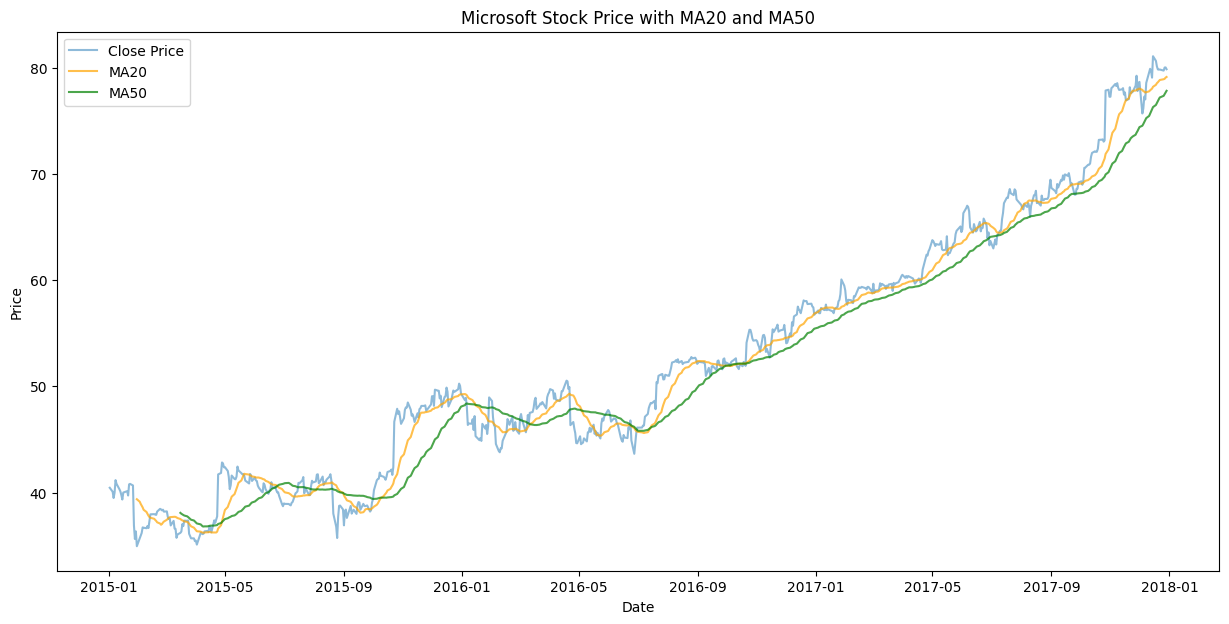

In [28]:
# Calculate MA20 ans MA50 from Close price
filtered_data['MA50'] = filtered_data['Close'].rolling(window=50).mean()
filtered_data['MA20'] = filtered_data['Close'].rolling(window=20).mean()
# plot MA20 and MA50
plt.figure(figsize=(15, 7))
plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', alpha=0.5)
plt.plot(filtered_data['Date'], filtered_data['MA20'], label='MA20', alpha=0.7, color='orange')
plt.plot(filtered_data['Date'], filtered_data['MA50'], label='MA50', alpha=0.7, color='green')
plt.title('Microsoft Stock Price with MA20 and MA50')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [29]:
# Function for Trading System with 1 mean buy -2 for short sell and other for close position
def command(y_pred_trend,y_true_price):
    command = []
    command_long = []
    command_short = []
    rate_by_time = []
    position = []
    rate_certain_time = []
    rate = 0
    pred=0
    pos=0
    count = 0
    for i in range(len(y_true_price)):
        if  y_pred_trend[i]==1:
                command.append(1)
                command_long.append(1)
                command_short.append(0)
                if pred !=1:
                    rate = rate + (y_true_price[i]-pos)*pred-0.15
                    pos =y_true_price[i]
                    count+=1
                pred=1
                position.append(pos)
                rate_by_time.append(rate)
        elif  y_pred_trend[i]==-2:
                command.append(-1)
                command_long.append(0)
                command_short.append(1)
                if pred !=-1:
                    rate = rate + (y_true_price[i]-pos)*pred-0.15
                    pos =y_true_price[i]
                    count+=1
                pred = -1
                position.append(pos)
                rate_by_time.append(rate)
        else:
            command.append(0)
            command_long.append(0)
            command_short.append(0)
            if pred != 0:
                rate = rate+ pred*(y_true_price[i]-pos) 
            pred = 0
            pos =0
            position.append(pos)
            rate_by_time.append(rate)
    return [y_true_price,command,command_long,command_short,rate_by_time,position], count      

In [30]:
# Calculate portfolio from Trading System
def portfolio_pnl_future(position_long, position_short, Close):
    a=0
    fee=[0]
    for i in range(1,len(t.L)):
        if t.L[i-1]>t.L[i] or t.S[i-1]>t.S[i]:
            a=a+1
            fee.append(a*0.15)
        else:
            fee.append(a*0.15)
    intitial_capital_long = (position_long.iloc[0])*(Close.iloc[0])
    cash_long = (position_long.diff()*Close)
    cash_long[0] = intitial_capital_long
    cash_cs_long = cash_long.cumsum()
    portfolio_value_long = (position_long *Close)

    intitial_capital_short = (position_short.iloc[0])*(Close.iloc[0])
    cash_short = (position_short.diff()* Close)
    cash_short[0] = intitial_capital_short
    cash_cs_short = cash_short.cumsum()
    portfolio_value_short = (position_short* Close)

    backtest = (portfolio_value_long - cash_cs_long).iloc[1:] + (cash_cs_short - portfolio_value_short).iloc[1:]-fee[1:]
    cash_max = (cash_long + cash_short).max()
    pnl =  backtest/cash_max
    
    return backtest, cash_max, pnl
def Sharp(pnl):
    r = pnl.diff(1)
    return np.abs(r.mean())/r.std() * np.sqrt(252)

def maximum_drawdown_future(backtest, cash_max):
    return (backtest.cummax() - backtest).max(), (backtest.cummax() - backtest).max()/cash_max

# Technical Trading models
1. Moving average

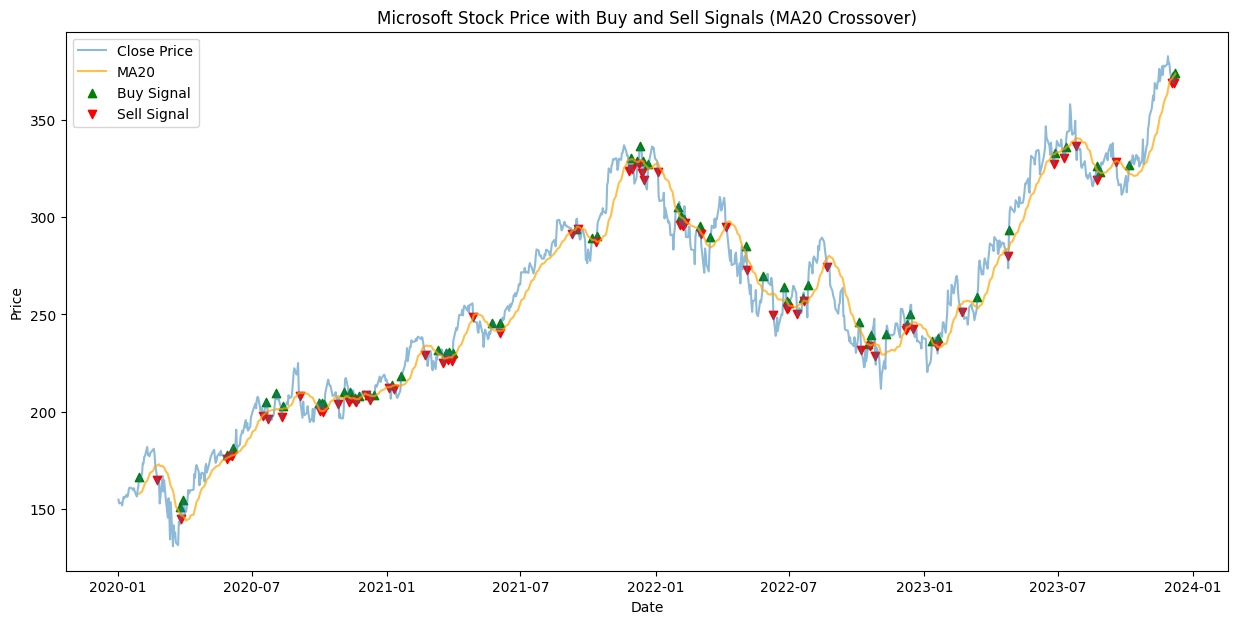

In [31]:
# Buy signal: Close price is above MA20
# Sell signal: Close price is below MA20
file_path = 'MSFT.csv'
msft_data = pd.read_csv(file_path)
msft_data['Date'] = pd.to_datetime(msft_data['Date'])

# Filter data for the last 5 years
latest_date = msft_data['Date'].max()
filtered_data = msft_data[msft_data['Date'] > '2020-01-01']
# Calculate the 20-day Moving Average (MA20)
filtered_data['MA20'] = filtered_data['Close'].rolling(window=20).mean()

# Generating buy and sell signals based on crossover with MA20
filtered_data['Signal'] = 0  # Default no signal
filtered_data['Signal'][filtered_data['Close'] > filtered_data['MA20']] = 1  # Buy signal
filtered_data['Signal'][filtered_data['Close'] < filtered_data['MA20']] = -1  # Sell signal

# Extracting buy and sell points for plotting
buy_signals = filtered_data[(filtered_data['Signal'] == 1) & (filtered_data['Signal'].shift(1) != 1)]
sell_signals = filtered_data[(filtered_data['Signal'] == -1) & (filtered_data['Signal'].shift(1) != -1)]

# Plotting the Close price, MA20, and buy/sell signals
plt.figure(figsize=(15, 7))
plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', alpha=0.5)
plt.plot(filtered_data['Date'], filtered_data['MA20'], label='MA20', alpha=0.7, color='orange')
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
plt.title('Microsoft Stock Price with Buy and Sell Signals (MA20 Crossover)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


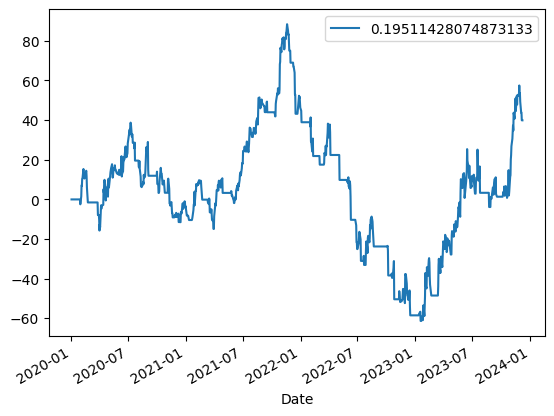

In [32]:
t,fee= command(filtered_data['Signal'].to_list(),filtered_data['Close'].reset_index(drop='index'))
t[0]=t[0].tolist()
t= pd.DataFrame(t).transpose()
t.columns=['Close','Command','L','S','Total_gain','Position']
t.index=filtered_data.Date

import numpy as np
backtest, cash_max,pnl= portfolio_pnl_future(t.L,t.S,t.Close)
backtest.index = pd.to_datetime(backtest.index)
pnl = portfolio_pnl_future(t.L, t.S, t.Close)[0]
pnl.index = pd.to_datetime(pnl.index)
pnl.index = pd.to_datetime(pnl.index)
pnl = pnl.resample('1D').last().dropna()
backtest.plot(label = Sharp(backtest.resample('1D').last().dropna()))
plt.legend()


2. Moving combine with Relative Strength Index

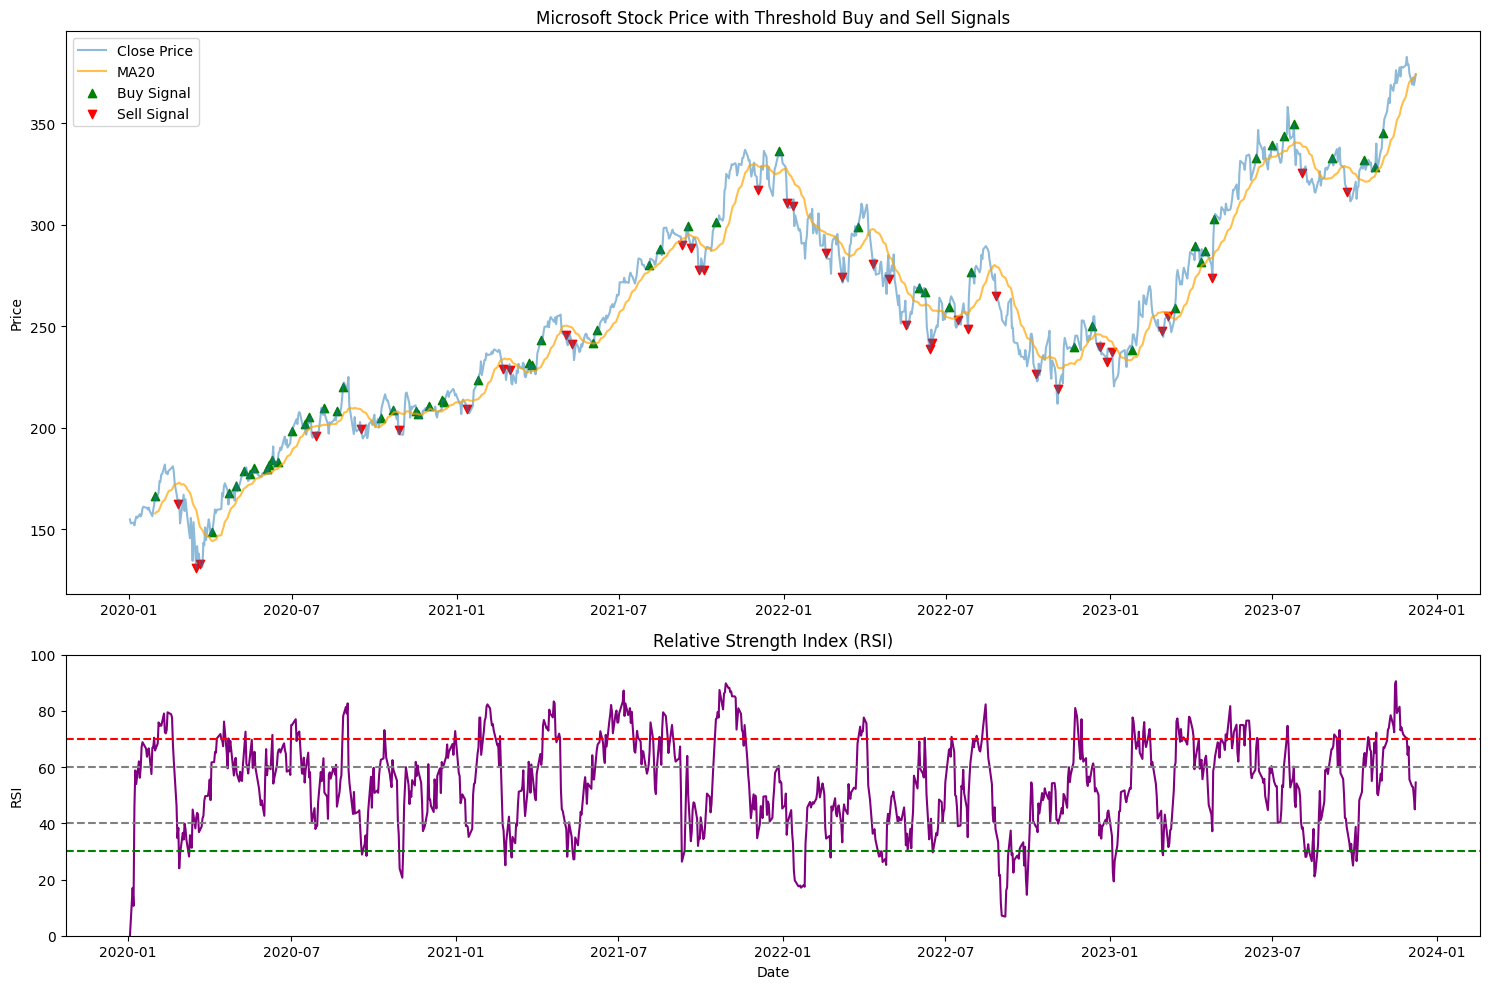

In [33]:
# Buy signal: RSI above 60 and Close price is above MA20
# Sell signal: RSI under 40 and Close price is below MA20
# Calculate RSI for the 'Close' prices
filtered_data['RSI'] = calculate_rsi(filtered_data['Close'])
# Updating the signals in the DataFrame
filtered_data['Threshold_Signal'] = 0  # Default no signal
filtered_data['Threshold_Signal'][(filtered_data['RSI'] > 60) & (filtered_data['Close'] > filtered_data['MA20'])] = 1  # Buy signal
filtered_data['Threshold_Signal'][(filtered_data['RSI'] < 40) & (filtered_data['Close'] < filtered_data['MA20'])] = -1  # Sell signal

# Extracting buy and sell points for the threshold strategy
threshold_buy_signals = filtered_data[(filtered_data['Threshold_Signal'] == 1) & (filtered_data['Threshold_Signal'].shift(1) != 1)]
threshold_sell_signals = filtered_data[(filtered_data['Threshold_Signal'] == -1) & (filtered_data['Threshold_Signal'].shift(1) != -1)]

# Plotting the Close price, MA20, RSI, and threshold buy/sell signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})

# Close price with threshold signals
ax1.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', alpha=0.5)
ax1.plot(filtered_data['Date'], filtered_data['MA20'], label='MA20', alpha=0.7, color='orange')
ax1.scatter(threshold_buy_signals['Date'], threshold_buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
ax1.scatter(threshold_sell_signals['Date'], threshold_sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
ax1.set_title('Microsoft Stock Price with Threshold Buy and Sell Signals')
ax1.set_ylabel('Price')
ax1.legend()

# RSI
ax2.plot(filtered_data['Date'], filtered_data['RSI'], color='purple')
ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='green', linestyle='--')
ax2.axhline(60, color='grey', linestyle='--')
ax2.axhline(40, color='grey', linestyle='--')
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()


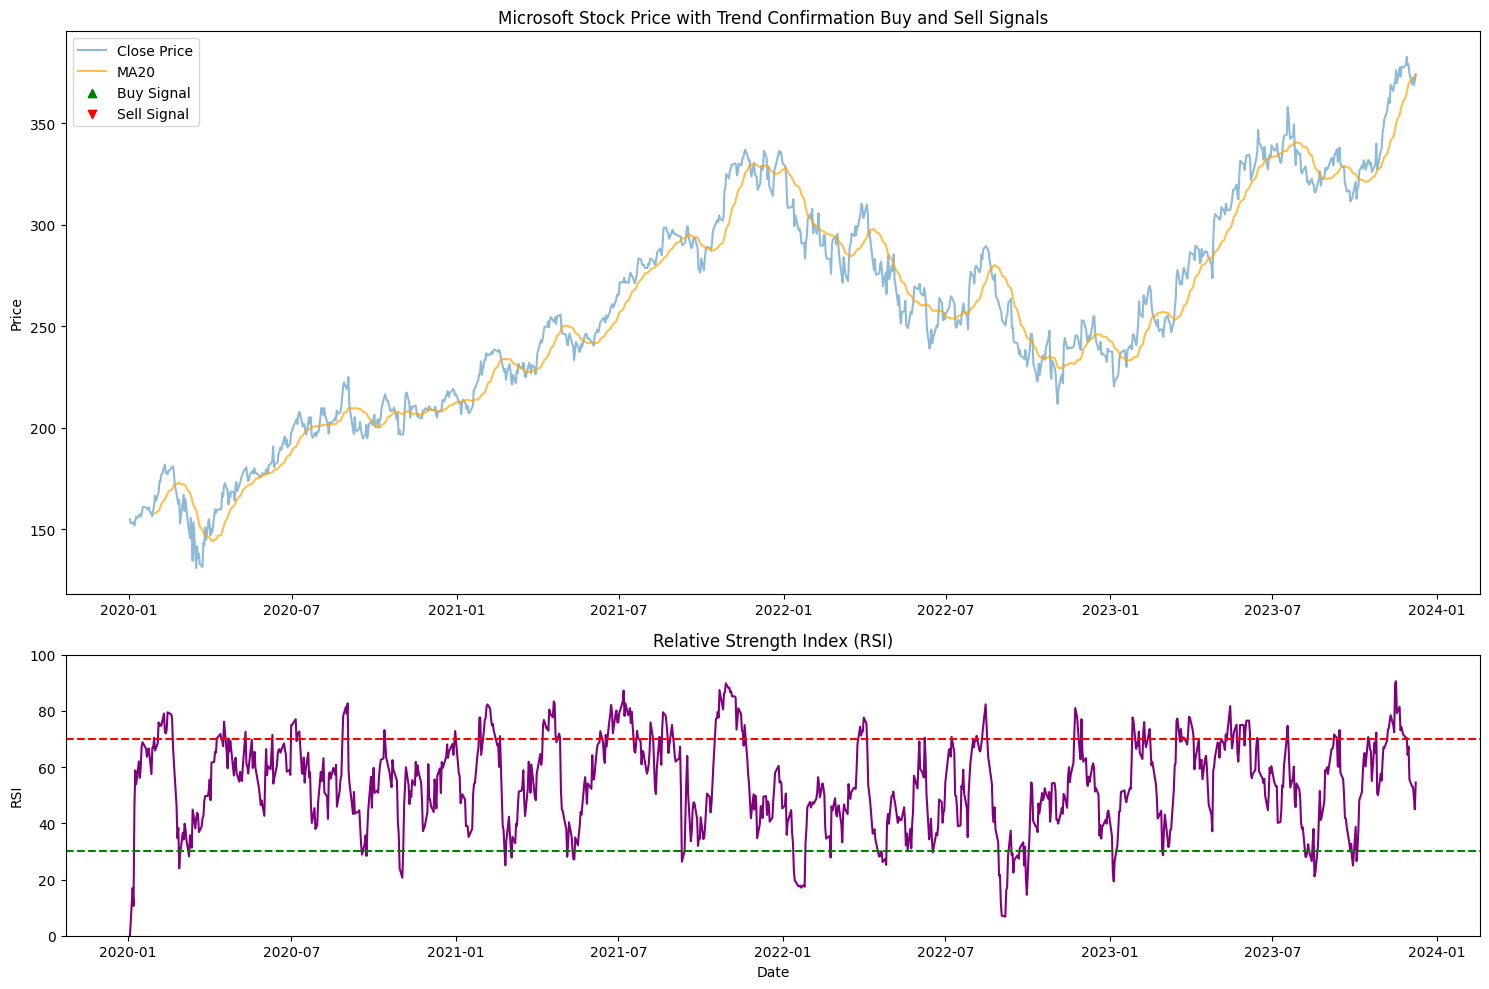

In [34]:
# Implementing the RSI Overbought/Oversold with MA20 Trend Confirmation Strategy
# Buy signal: RSI is below 30 and the Close price is above MA20
# Sell signal: RSI is above 70 and the Close price is below MA20

# Updating the signals in the DataFrame
filtered_data['Trend_Confirm_Signal'] = 0  # Default no signal
filtered_data['Trend_Confirm_Signal'][(filtered_data['RSI'] < 30) & (filtered_data['Close'] > filtered_data['MA20'])] = 1  # Buy signal
filtered_data['Trend_Confirm_Signal'][(filtered_data['RSI'] > 70) & (filtered_data['Close'] < filtered_data['MA20'])] = -1  # Sell signal

# Extracting buy and sell points for the trend confirmation strategy
trend_confirm_buy_signals = filtered_data[(filtered_data['Trend_Confirm_Signal'] == 1) & (filtered_data['Trend_Confirm_Signal'].shift(1) != 1)]
trend_confirm_sell_signals = filtered_data[(filtered_data['Trend_Confirm_Signal'] == -1) & (filtered_data['Trend_Confirm_Signal'].shift(1) != -1)]

# Plotting the Close price, MA20, RSI, and trend confirmation buy/sell signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})

# Close price with trend confirmation signals
ax1.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', alpha=0.5)
ax1.plot(filtered_data['Date'], filtered_data['MA20'], label='MA20', alpha=0.7, color='orange')
ax1.scatter(trend_confirm_buy_signals['Date'], trend_confirm_buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
ax1.scatter(trend_confirm_sell_signals['Date'], trend_confirm_sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
ax1.set_title('Microsoft Stock Price with Trend Confirmation Buy and Sell Signals')
ax1.set_ylabel('Price')
ax1.legend()

# RSI
ax2.plot(filtered_data['Date'], filtered_data['RSI'], color='purple')
ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='green', linestyle='--')
ax2.set_title('Relative Strength Index (RSI)')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()


It seems that there is nothing Signal to buy or sell as the Conditional is following a divergent but it quite hard to figure out.

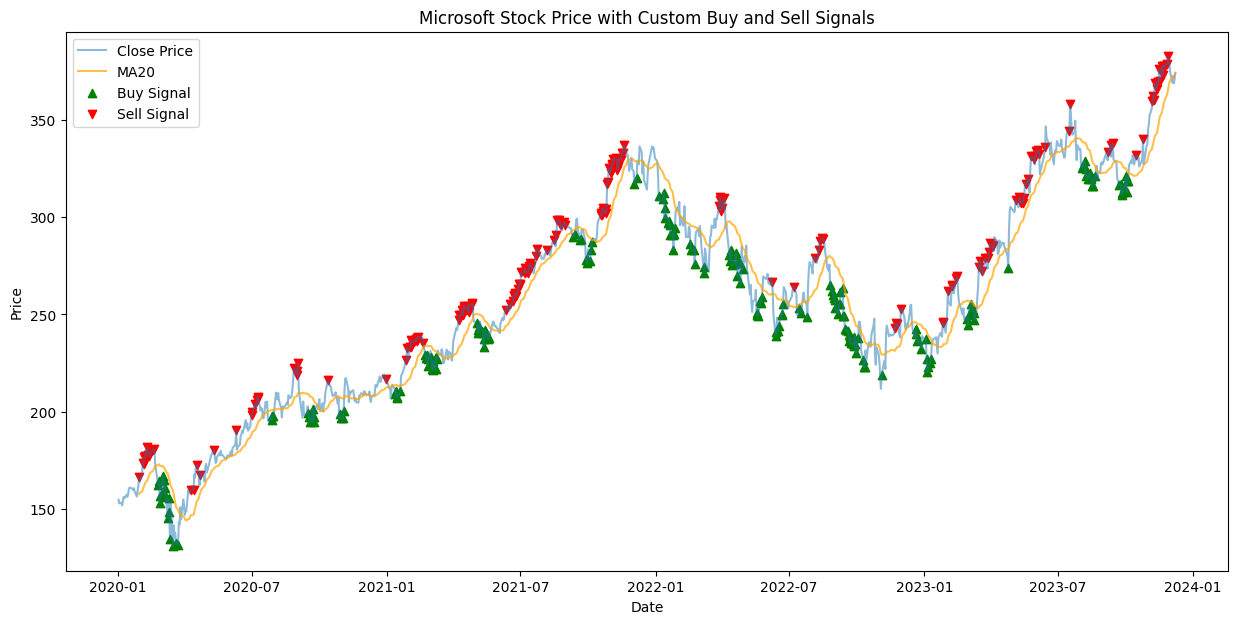

In [35]:
# Recreating MA20 crossover indicators
filtered_data['MA20_Cross_Over'] = filtered_data['Close'] > filtered_data['MA20']
filtered_data['MA20_Cross_Under'] = filtered_data['Close'] < filtered_data['MA20']

# Implementing the custom buy and sell signal strategy
filtered_data['Custom_Buy_Sell_Signal'] = 0
# Buy signal: Price crosses under MA20 and RSI <= 40
filtered_data['Custom_Buy_Sell_Signal'][(filtered_data['MA20_Cross_Under']) & (filtered_data['RSI'] <= 40)] = 1
# Sell signal: RSI crosses over 60 and price is over MA20
filtered_data['Custom_Buy_Sell_Signal'][(filtered_data['RSI'] > 70) & (filtered_data['MA20_Cross_Over'])] = -1

# Extracting buy and sell points for plotting
custom_buy_signals = filtered_data[filtered_data['Custom_Buy_Sell_Signal'] == 1]
custom_sell_signals = filtered_data[filtered_data['Custom_Buy_Sell_Signal'] == -1]

# Plotting the Close price, MA20, RSI, and custom buy/sell signals
plt.figure(figsize=(15, 7))
plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', alpha=0.5)
plt.plot(filtered_data['Date'], filtered_data['MA20'], label='MA20', alpha=0.7, color='orange')
plt.scatter(custom_buy_signals['Date'], custom_buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(custom_sell_signals['Date'], custom_sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
plt.title('Microsoft Stock Price with Custom Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


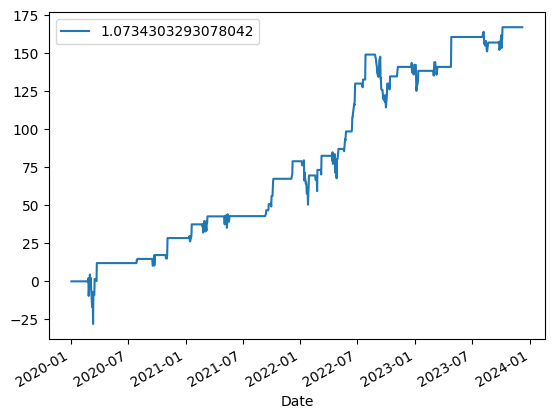

In [36]:
t,fee= command(filtered_data['Custom_Buy_Sell_Signal'].to_list(),filtered_data['Close'].reset_index(drop='index'))
t[0]=t[0].tolist()
t= pd.DataFrame(t).transpose()
t.columns=['Close','Command','L','S','Total_gain','Position']
t.index=filtered_data.Date

import numpy as np
backtest, cash_max,pnl= portfolio_pnl_future(t.L,t.S,t.Close)
backtest.index = pd.to_datetime(backtest.index)
pnl = portfolio_pnl_future(t.L, t.S, t.Close)[0]
pnl.index = pd.to_datetime(pnl.index)
pnl.index = pd.to_datetime(pnl.index)
pnl = pnl.resample('1D').last().dropna()
backtest.plot(label = Sharp(backtest.resample('1D').last().dropna()))
plt.legend()
